In [1]:
import os
os.chdir("/Users/User/P2")
print(os.getcwd())

C:\Users\User\P2


In [2]:
import pandas as pd
import numpy as np 

#load the data
data = pd.read_csv('MST_chl_nn-cleaned.csv')
print(data.shape)
print(data.info())

(1640, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1640 non-null   object 
 1   MST_chl_nn  1640 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB
None


In [3]:
# ADF Test = testing if data is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['MST_chl_nn'])

def adfuller_test(MST_chl_nn):
    result=adfuller(MST_chl_nn)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['MST_chl_nn'])

strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
ADF Test Statistic : -7.789440215646913
p-value : 8.014994236725313e-12
#Lags Used : 1
Number of Observations : 1638


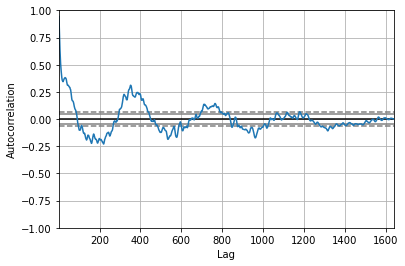

In [4]:
#autocorrelation

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline

autocorrelation_plot(data['MST_chl_nn'])
plt.show()

In [5]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]
valid = data[int(0.7*(len(data))):]

#preprocessing (since arima takes univariate series as input)
train.drop('Date',axis=1,inplace=True)
valid.drop('Date',axis=1,inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


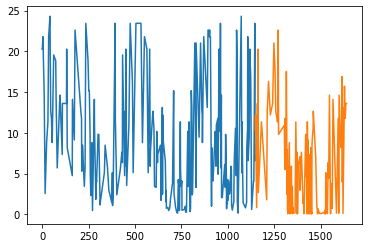

In [6]:
#plotting the data

train['MST_chl_nn'].plot()
valid['MST_chl_nn'].plot()

In [18]:
#building the model (with optimal p,d,q value)
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit=model.fit(train)

model_fit


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4910.970, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4969.804, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4948.902, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4950.689, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4967.831, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4950.637, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4951.294, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4908.469, Time=2.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4912.471, Time=1.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4915.214, Time=1.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4914.788, Time=1.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4912.967, Time=1.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4914.015, Time=1.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4915.730, Time=1.88 sec
 ARIMA(3,1,2)(0,0,0)[0]          

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1148
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2447.122
Date:                Mon, 24 Jan 2022   AIC                           4906.245
Time:                        17:05:42   BIC                           4936.514
Sample:                             0   HQIC                          4917.672
                               - 1148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0680      0.020    101.814      0.000       2.028       2.108
ar.L2         -1.2244      0.032    -37.897      0.000      -1.288      -1.161
ar.L3          0.1480      0.016      9.268      0.000       0.117       0.179
ma.L1         -1.9670      0.015   -132.650      0.000      -1.996      -1.938
ma.L2          0.9707      0.014     67.313      0.000       0.942       0.999
sigma2         4.1717      0.067     61.963      0.000       4.040       4.304
===================================================================================
Ljung-Box (Q):                       43.23   Jarque-Bera (JB):             23328.01
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               4.60   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

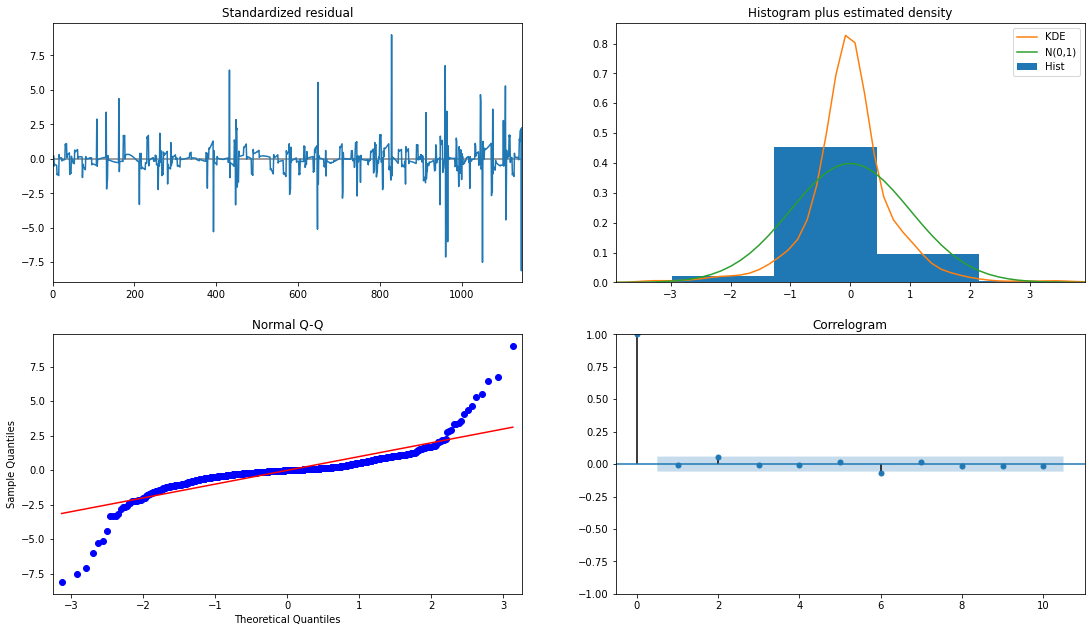

In [14]:
fig = model_fit.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)

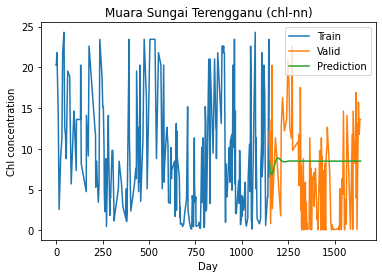

In [15]:
#plot the predictions for validation set

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.xlabel("Day")
plt.ylabel("Chl concentration")
plt.legend(loc="upper right")
plt.title("Muara Sungai Terengganu (chl-nn)")
plt.show()

In [12]:
#model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score


print('Mean Absolute Error:', metrics.mean_absolute_error(valid,forecast))
print('Mean Squared Error:', metrics.mean_squared_error(valid,forecast))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(valid,forecast)))
print('R Squared value:',r2_score(valid,forecast))

Mean Absolute Error: 4.572441209677607
Mean Squared Error: 29.0733913595227
Root Mean Squared Error: 5.391974717997359
R Squared value: -0.09755937904120349
